In [31]:
import math
import numpy as np
import pandas as pd
import random
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

In [32]:
dataset_location = "/Users/Xutao/Documents/CR4CR/dataset/"

In [33]:
df = pd.read_excel(dataset_location + "Market 00abc_240310.xlsx")
df = df.iloc[:,1:]
df.fillna('', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Respondent Id             598 non-null    int64 
 1   Assignment Id             598 non-null    int64 
 2   Class                     598 non-null    object
 3   Activities                598 non-null    object
 4   Market.00a_OE             598 non-null    object
 5   Market.00bc_OE            598 non-null    object
 6   Market.00bc_OE follow up  598 non-null    object
 7   Score                     598 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 37.5+ KB


In [34]:
len(df['Score'])

598

<Axes: xlabel='Score'>

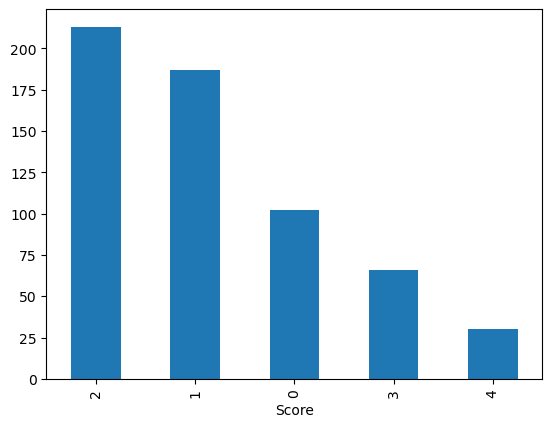

In [35]:
# plot the grade distribution
df['Score'].value_counts().plot(kind='bar')

In [36]:
for col in ["Market.00a_OE", "Market.00bc_OE", "Market.00bc_OE follow up"]:
    df[col] = df[col].astype(str)

In [37]:
from transformers import BertTokenizer, BertModel, DistilBertPreTrainedModel, RobertaForSequenceClassification
#from transformers.modeling_distilbert import DistilBertModel, DistilBertPreTrainedModel
from torch import nn
from sklearn.preprocessing import OneHotEncoder


class MultimodalRoberta(torch.nn.Module):
    def __init__(self, num_labels=5): 
        super(MultimodalRoberta, self).__init__()
        self.num_labels = num_labels
        self.roberta1 = RobertaModel.from_pretrained('distilroberta-base')
        self.roberta2 = RobertaModel.from_pretrained('distilroberta-base')
        self.roberta3 = RobertaModel.from_pretrained('distilroberta-base')
        self.classifier = nn.Linear(self.roberta1.config.hidden_size + self.roberta2.config.hidden_size + self.roberta3.config.hidden_size, num_labels)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, input_ids_c, attention_mask_c):
        output_a = self.roberta1(input_ids=input_ids_a, attention_mask=attention_mask_a)
        output_b = self.roberta2(input_ids=input_ids_b, attention_mask=attention_mask_b)
        output_c = self.roberta3(input_ids=input_ids_c, attention_mask=attention_mask_c)

        concatenated_output = torch.cat((output_a.pooler_output, output_b.pooler_output, output_c.pooler_output), 1)

        return self.classifier(concatenated_output)


class MultimodalRobertaDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.columns = ["Market.00a_OE", "Market.00bc_OE", "Market.00bc_OE follow up"]
        self.labels = self.dataframe['Score'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        # Selecting sentence1 and sentence2 at the specified index in the data frame
        row = self.dataframe.iloc[index]
        response_a = row['Market.00a_OE']
        response_b = row['Market.00bc_OE']
        response_c = row['Market.00bc_OE follow up']
        score = row['Score']

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoding_a = self.tokenizer.encode_plus(response_a, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)
        encoding_b = self.tokenizer.encode_plus(response_b, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)
        encoding_c = self.tokenizer.encode_plus(response_c, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)

        return {
            'input_ids_a': torch.tensor(encoding_a['input_ids'], dtype=torch.long),
            'attention_mask_a': torch.tensor(encoding_a['attention_mask'], dtype=torch.long),
            'input_ids_b': torch.tensor(encoding_b['input_ids'], dtype=torch.long),
            'attention_mask_b': torch.tensor(encoding_b['attention_mask'], dtype=torch.long),
            'input_ids_c': torch.tensor(encoding_c['input_ids'], dtype=torch.long),
            'attention_mask_c': torch.tensor(encoding_c['attention_mask'], dtype=torch.long),
            'score': torch.tensor(score, dtype=torch.float)
        }

In [38]:
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', output_attentions=False)

# First split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=42)



# Create datasets
train_dataset = MultimodalRobertaDataset(train_df, tokenizer)
test_dataset = MultimodalRobertaDataset(test_df, tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2)  # changed batch_size to 3
test_loader = DataLoader(test_dataset, batch_size=2)  # new line, changed batch_size to 3

model = MultimodalRoberta()
device = torch.device('cuda:0')
model.to(device)

MultimodalRoberta(
  (roberta1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [39]:
torch.cuda.is_available()

True

In [40]:
train_df.iloc[16]

Respondent Id                                                           29301
Assignment Id                                                           75317
Class                       AP_Computer_Science_Principles-2324 (Nathalie ...
Activities                                             Fall 2023 CoT Form BA2
Market.00a_OE               The team must know how to set it up, and using...
Market.00bc_OE              The most important pieces are setting up progr...
Market.00bc_OE follow up    These are important because it's common sense ...
Score                                                                       1
Name: 312, dtype: object

In [41]:
#loss_function = nn.MSELoss()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [42]:
for epoch in range(7):
    total_loss = 0
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(
            batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
            batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
            batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
        )
        loss = loss_function(outputs, batch['score'].to(device).long())
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))

Average training loss: 1.10
Average training loss: 0.60
Average training loss: 0.38
Average training loss: 0.28
Average training loss: 0.14
Average training loss: 0.06
Average training loss: 0.04


In [43]:
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
      # Forward pass
      outputs = model(
          batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
          batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
          batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
      )
      #all_predictions.extend(outputs.cpu().numpy())
      #all_labels.extend(batch['score'].numpy())

      _, outputs = torch.max(outputs, 1)
      all_predictions.extend(outputs.cpu().numpy())
      all_labels.extend(batch['score'].numpy())

# Since my predictions return float number, such as 2.3 and 3.5, I decide to round
# or map the number in the following way:
# 2.5 -> 3; 2.3 -> 2; to get a better algorithm to calculate the accuracy

def arrayround(arr,n=0):
    import numpy as np
    flag = np.where(arr>=0,1,-1)
    arr = np.abs(arr)
    arr10 = arr*10**(n+1)
    arr20 = np.floor(arr10)
    arr30 = np.where(arr20%10==5,(arr20+1)/10**(n+1),arr20/10**(n+1))
    result = np.around(arr30,n)
    return result*flag

all_predictions = np.array(all_predictions).flatten()
#all_predictions = arrayround(all_predictions)



# Compute the average accuracy over all batches
correct_predictions = sum(all_predictions == np.array(all_labels))
total_predictions = len(all_predictions)
test_accuracy = correct_predictions / total_predictions

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Accuracy: 63.33%


In [44]:
torch.cuda.empty_cache()
del model

Epoch 1/5, Validation loss: 1.0443947261030024, Validation accuracy: 0.2598450491307634
Epoch 2/5, Validation loss: 0.8952670534226027, Validation accuracy: 0.307059477399472
Epoch 3/5, Validation loss: 0.8246364625678821, Validation accuracy: 0.32713564811766294
Epoch 4/5, Validation loss: 0.8980642328546806, Validation accuracy: 0.3369408338464587
Epoch 5/5, Validation loss: 0.8042453239587221, Validation accuracy: 0.3440228680186215


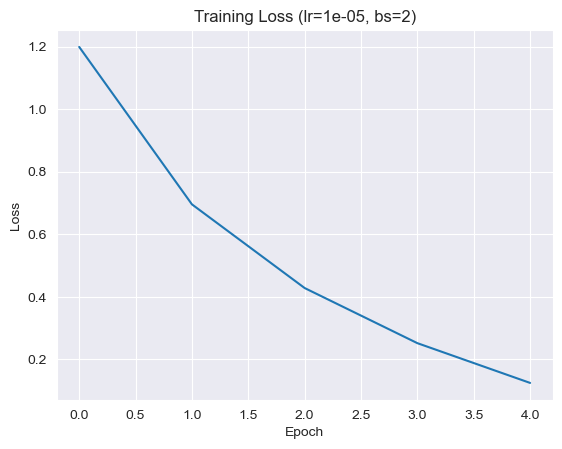

Epoch 1/5, Validation loss: 1.2005080183347066, Validation accuracy: 0.18446964382347536
Epoch 2/5, Validation loss: 1.015982170899709, Validation accuracy: 0.18126863623525116
Epoch 3/5, Validation loss: 0.9223122869928678, Validation accuracy: 0.18449512074257096
Epoch 4/5, Validation loss: 0.734497144818306, Validation accuracy: 0.18762302216933094
Epoch 5/5, Validation loss: 0.5867614423235258, Validation accuracy: 0.18881591548258872


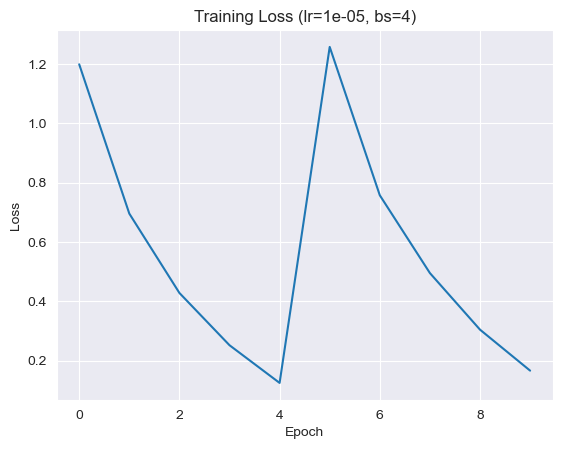

Epoch 1/5, Validation loss: 1.1912415027618408, Validation accuracy: 0.339759541140758
Epoch 2/5, Validation loss: 1.1042807630517266, Validation accuracy: 0.3362172223960757
Epoch 3/5, Validation loss: 1.5362108078869907, Validation accuracy: 0.32596207553182555
Epoch 4/5, Validation loss: 0.9648614146492698, Validation accuracy: 0.3200552303971452
Epoch 5/5, Validation loss: 1.0315649942918257, Validation accuracy: 0.3186320605889946


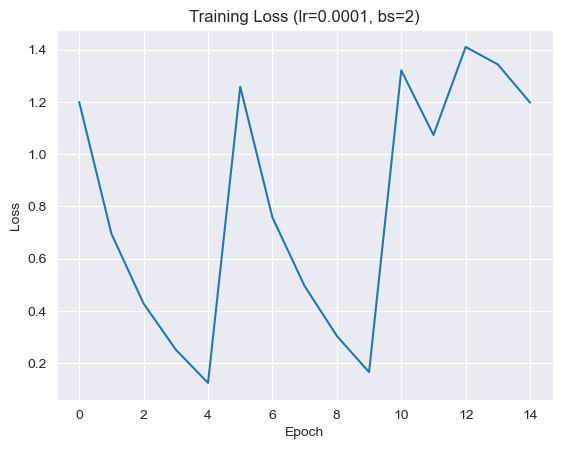

Epoch 1/5, Validation loss: 1.1935649464527767, Validation accuracy: 0.17351491305380634
Epoch 2/5, Validation loss: 1.3145687480767567, Validation accuracy: 0.17330135669058203
Epoch 3/5, Validation loss: 0.8412511696418127, Validation accuracy: 0.17375915247709442
Epoch 4/5, Validation loss: 1.3685395816961925, Validation accuracy: 0.17489702016919562
Epoch 5/5, Validation loss: 1.1118957325816154, Validation accuracy: 0.17581481163244125


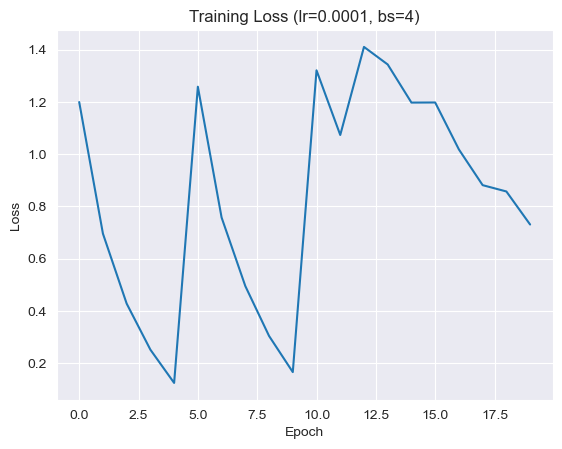

Epoch 1/5, Validation loss: 1.6030528816309841, Validation accuracy: 0.3155747898873074
Epoch 2/5, Validation loss: 1.9742045267061754, Validation accuracy: 0.30787895695037226
Epoch 3/5, Validation loss: 1.5239462581547825, Validation accuracy: 0.3008655242025031
Epoch 4/5, Validation loss: 1.4381498260931536, Validation accuracy: 0.29444756715783127
Epoch 5/5, Validation loss: 2.5930299921469255, Validation accuracy: 0.2885523253752683


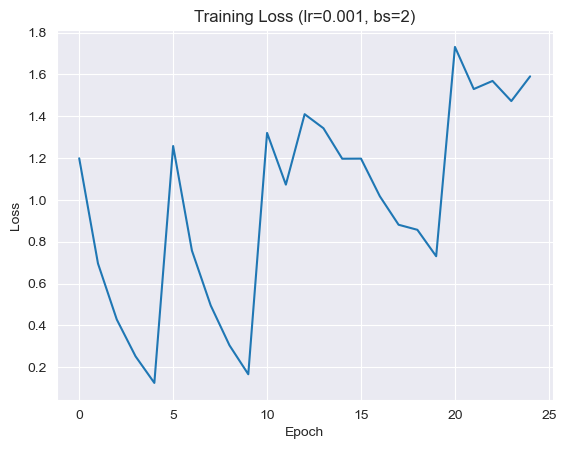

Epoch 1/5, Validation loss: 1.6388907829920452, Validation accuracy: 0.1542270387011387
Epoch 2/5, Validation loss: 1.4388380646705627, Validation accuracy: 0.15150173907851402
Epoch 3/5, Validation loss: 1.4947269360224407, Validation accuracy: 0.1489736814722185
Epoch 4/5, Validation loss: 1.5134142835934956, Validation accuracy: 0.14662219858127323
Epoch 5/5, Validation loss: 1.4881025155385335, Validation accuracy: 0.1444294133359306


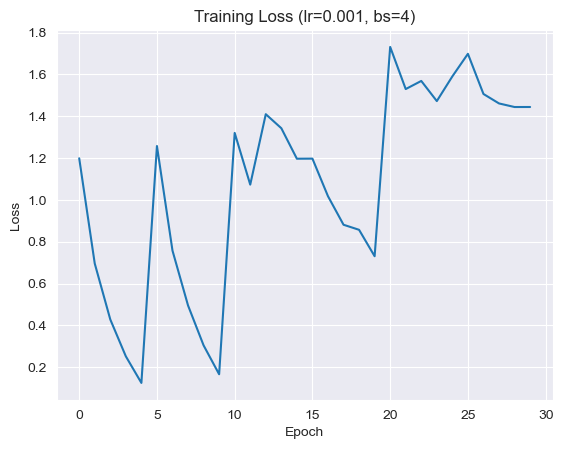

Epoch 1/5, Validation loss: 22.2247840274464, Validation accuracy: 0.2626904857515409
Epoch 2/5, Validation loss: 20.708342638882392, Validation accuracy: 0.25774702300475016
Epoch 3/5, Validation loss: 9.848997744646939, Validation accuracy: 0.25381112737288447
Epoch 4/5, Validation loss: 29.82011284357445, Validation accuracy: 0.24833339550323566
Epoch 5/5, Validation loss: 17.60722112596903, Validation accuracy: 0.24547844323204596


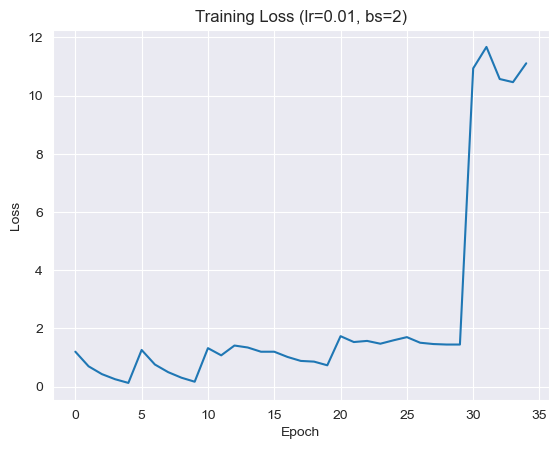

Epoch 1/5, Validation loss: 8.366212613356765, Validation accuracy: 0.13233015454261987
Epoch 2/5, Validation loss: 3.6524242162704468, Validation accuracy: 0.1315658583372864
Epoch 3/5, Validation loss: 5.585489670435588, Validation accuracy: 0.13023921758169466
Epoch 4/5, Validation loss: 15.531296074389275, Validation accuracy: 0.12839393213196834
Epoch 5/5, Validation loss: 8.42163293901831, Validation accuracy: 0.1272142669661254


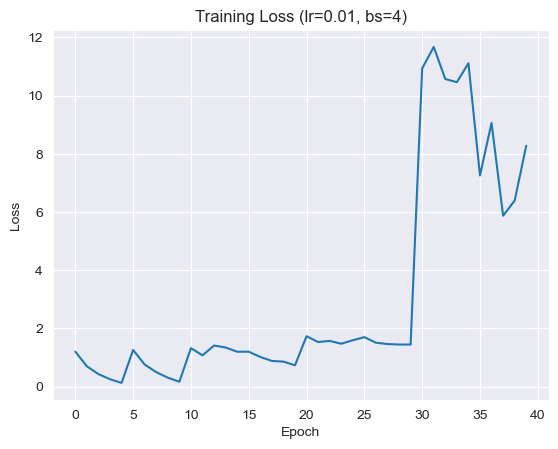

Epoch 1/5, Validation loss: 224.0838761763139, Validation accuracy: 0.23130503504636787
Epoch 2/5, Validation loss: 7.185601158575579, Validation accuracy: 0.23070543781971548
Epoch 3/5, Validation loss: 95.80613777854226, Validation accuracy: 0.2290653551133324
Epoch 4/5, Validation loss: 65.35543268377131, Validation accuracy: 0.22724262730079658
Epoch 5/5, Validation loss: 217.66150457208806, Validation accuracy: 0.2245362640417372


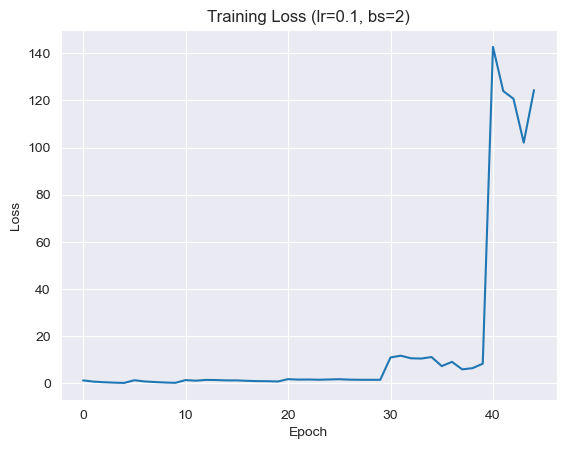

Epoch 1/5, Validation loss: 48.85004038860401, Validation accuracy: 0.12152001280566123
Epoch 2/5, Validation loss: 90.42195008198405, Validation accuracy: 0.1213468276705852
Epoch 3/5, Validation loss: 57.508323669433594, Validation accuracy: 0.12013106825975244
Epoch 4/5, Validation loss: 49.72675704956055, Validation accuracy: 0.11901623375451824
Epoch 5/5, Validation loss: 286.8833821614583, Validation accuracy: 0.1174836689385822


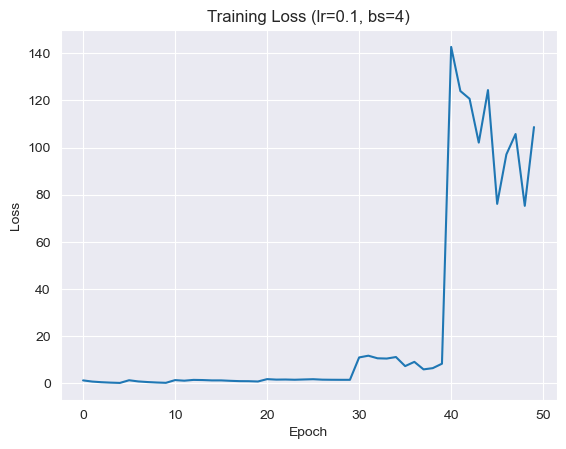

Best learning rate found: 1e-05, Best batch size found: 2 with validation accuracy: 0.3440228680186215


In [ ]:
import matplotlib.pyplot as plt

# Set possible learning rates and batch sizes
learning_rates = [1e-5, 1e-4, 1e-3,1e-2,1e-1]
batch_sizes = [2,4]

# Placeholder for the best parameters
best_acc = 0.0
best_lr = 0.0
best_bs = 0

# Placeholder for the plot data
history = []
all_predictions = []
all_labels = []

for lr in learning_rates:
    for bs in batch_sizes:

        # Create new DataLoaders for each batch size
        train_loader = DataLoader(train_dataset, batch_size=bs) 
        val_loader = DataLoader(val_dataset, batch_size=bs)

        # Initialize a new model and optimizer for each learning rate
        model = MultimodalRoberta().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train for some epochs
        EPOCHS = 5

        for epoch in range(EPOCHS):
            model.train()
            training_loss = 0

            for batch in train_loader:
                
                
                optimizer.zero_grad()
                outputs = model(
                    batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                    batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                    batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
                )
                loss = loss_function(outputs, batch['score'].to(device).long())
                training_loss += loss.item()
        
                loss.backward()
                optimizer.step()
                

            # Send the training loss to the history
            history.append(training_loss / len(train_loader))

            # Validate the model
            model.eval()
            val_loss = 0
            val_correct = 0
            with torch.no_grad():
            
                    
                for batch in val_loader:
                    
                    outputs = model(
                    batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                    batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                    batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
                    )
                    loss = loss_function(outputs, batch['score'].to(device).long())
                    val_loss += loss.item()
        
                    # Compute acccuracy
                    _, outputs = torch.max(outputs, 1)
                    all_predictions.extend(outputs.cpu().numpy())
                    all_labels.extend(batch['score'].numpy())
                    correct = sum(all_predictions == np.array(all_labels))/len(all_predictions) # convert into float for division 
                    val_correct += correct.sum().item()

            # Compute average validation loss and accuracy
            avg_val_loss = val_loss / len(val_loader)
            avg_val_acc = val_correct / len(val_loader.dataset)
            
            print(f'Epoch {epoch+1}/{EPOCHS}, Validation loss: {avg_val_loss}, Validation accuracy: {avg_val_acc}')

            # If this model's parameters give better accuracy, update best_acc and best_lr and best_bs
            if avg_val_acc > best_acc:
                best_acc = avg_val_acc
                best_lr = lr
                best_bs = bs

        # Plotting the training loss
        plt.plot(history)
        plt.title(f"Training Loss (lr={lr}, bs={bs})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

print(f"Best learning rate found: {best_lr}, Best batch size found: {best_bs} with validation accuracy: {best_acc}")

In [ ]:
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
      # Forward pass
      outputs = model(
          batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
          batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
          batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
      )
      #all_predictions.extend(outputs.cpu().numpy())
      #all_labels.extend(batch['score'].numpy())

      _, outputs = torch.max(outputs, 1)
      all_predictions.extend(outputs.cpu().numpy())
      all_labels.extend(batch['score'].numpy())

# Since my predictions return float number, such as 2.3 and 3.5, I decide to round
# or map the number in the following way:
# 2.5 -> 3; 2.3 -> 2; to get a better algorithm to calculate the accuracy

def arrayround(arr,n=0):
    import numpy as np
    flag = np.where(arr>=0,1,-1)
    arr = np.abs(arr)
    arr10 = arr*10**(n+1)
    arr20 = np.floor(arr10)
    arr30 = np.where(arr20%10==5,(arr20+1)/10**(n+1),arr20/10**(n+1))
    result = np.around(arr30,n)
    return result*flag

all_predictions = np.array(all_predictions).flatten()
#all_predictions = arrayround(all_predictions)



# Compute the average accuracy over all batches
correct_predictions = sum(all_predictions == np.array(all_labels))
total_predictions = len(all_predictions)
test_accuracy = correct_predictions / total_predictions

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Accuracy: 28.57%


In [ ]:
# load a new dataset for prediction
import re
prediction_data = pd.read_excel(dataset_location + "Fall 23 Market_roderick.xlsx")
prediction_data = prediction_data.rename(columns={"Market.00bc_OE":"Market.00b_OE", "Market.00bc_OE follow up": 'Market.00c_OE', "Waypoints": "Score"})
def preprocess_text(text):
    # Lowercase the text
    # text = text.lower()

    text = re.sub(r'\n', ' ', text)
    #text = re.sub(r'^\w+\s*$', '',text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)


    return text


# Ensure data types of responses are string
for col in ["Market.00a_OE", "Market.00b_OE", "Market.00c_OE"]:
  prediction_data[col] = prediction_data[col].astype(str).apply(preprocess_text)
  
prediction_dataset = MultimodalRobertaDataset(prediction_data, tokenizer)
prediction_dataloader = DataLoader(prediction_dataset, batch_size=2)

all_predictions = []

with torch.no_grad():
    for batch in prediction_dataloader:
      # Forward pass
      outputs = model(
          batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
          batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
          batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
      )
      #all_predictions.extend(outputs.cpu().numpy())
      #all_labels.extend(batch['score'].numpy())

      _, outputs = torch.max(outputs, 1)
      all_predictions.extend(outputs.cpu().numpy())
      all_labels.extend(batch['score'].numpy())

all_predictions = np.array(all_predictions).flatten()

# add one more column to the dataset
prediction_data['predict_by_model'] = all_predictions

In [ ]:
prediction_data.to_excel(dataset_location + "Fall 2023 Market_roderick and model comparison.xlsx")

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Define the hyperparameter search space
learning_rates = [1e-5]  # List of learning rates to try
batch_sizes = [4, 8, 16, 32]  # List of batch sizes to try
epoch_sizes = [5,6,7,8,9,10]
combination_accuracies = {}

for epoch_size in epoch_sizes:
  for batch_size in batch_sizes:
    # Re-training the model for each combination of hyperparameters
    model = MultimodalRoberta()
    device = torch.device('cuda')
    model.to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model.train()
    print([epoch_size, batch_size]) # prints out the hyperparameter combination being tested
    for epoch in range(epoch_size):
        total_loss = 0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(
                batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
            )
            loss = loss_function(outputs, batch['score'].to(device).long())
            total_loss += loss.item()
    
            loss.backward()
            optimizer.step()
    # Put the model in evaluation mode
    model.eval()

    # Initialize variables to keep track of predictions and ground truth labels
    all_predictions = []
    all_labels = []

    # Evaluate on the test dataset
    with torch.no_grad():
        for batch in val_loader:
          # Forward pass
          outputs = model(
              batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
              batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
              batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
          )
          #all_predictions.extend(outputs.cpu().numpy())
          #all_labels.extend(batch['score'].numpy())
    
          _, outputs = torch.max(outputs, 1)
          all_predictions.extend(outputs.cpu().numpy())
          all_labels.extend(batch['score'].numpy())

    # Calculate accuracy
    all_predictions = np.array(all_predictions).flatten()

    correct_predictions = sum(all_predictions == np.array(all_labels))
    total_predictions = len(all_predictions)
    test_accuracy = correct_predictions / total_predictions
    
    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

    combination_accuracies[(epoch_size, batch_size)] = test_accuracy

    # Deletes the cache and the model from GPU memory
    torch.cuda.empty_cache()
    del model

[5, 4]
Test Accuracy: 76.19%
[5, 8]
Test Accuracy: 66.67%
[5, 16]
Test Accuracy: 61.90%
[5, 32]
Test Accuracy: 57.14%
[6, 4]
Test Accuracy: 66.67%
[6, 8]
Test Accuracy: 71.43%
[6, 16]
Test Accuracy: 57.14%
[6, 32]
Test Accuracy: 57.14%
[7, 4]
Test Accuracy: 57.14%
[7, 8]
Test Accuracy: 61.90%
[7, 16]
Test Accuracy: 61.90%
[7, 32]
Test Accuracy: 66.67%
[8, 4]
Test Accuracy: 71.43%
[8, 8]
Test Accuracy: 57.14%
[8, 16]
Test Accuracy: 61.90%
[8, 32]
Test Accuracy: 66.67%
[9, 4]
Test Accuracy: 71.43%
[9, 8]
Test Accuracy: 66.67%
[9, 16]
Test Accuracy: 66.67%
[9, 32]
Test Accuracy: 66.67%
[10, 4]
Test Accuracy: 61.90%
[10, 8]
Test Accuracy: 71.43%
[10, 16]
Test Accuracy: 71.43%
[10, 32]
Test Accuracy: 80.95%


In [ ]:
torch.cuda.empty_cache()
del model

NameError: name 'model' is not defined

In [ ]:
val_df[['Score']]

In [ ]:
val_df['predicted_score'] = all_predictions

In [ ]:
val_df

In [ ]:
output_df.to_excel("/workspace/difference.xlsx")

In [ ]:
output_df = val_df[val_df["Score"] != val_df["predicted_score"]]
output_df

In [ ]:
len(val_df)